# PROJECT PYTHON

## Шаг 1: Выбор темы проекта

Цель нашего проекта - спарсить данные с сайта IMDb о 1000 фильмах из топ-1000 по рейтингу, провести проразведочный анализ данных, EDA, выдвинуть гипотезы, проверить эти гипотезы с помощью математической статистики, попробовать предсказать переменную, проанализировать получившиеся результаты и сделать выводы. 

## Шаг 2: Спарсить данные

### Необходимо: 

1) Используя библиотеку requests, отправить GET-запрос на страницу 

2) Используя библиотеку Beautiful Soup, получить HTML-код страницы

3) Используя Beautiful Soup, извлечь необходимые данные о фильмах, их признаки для дальнейшего анализа

4) Сохранить полученные данные в файл в формате DataFrame для дальнейшего использования

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from time import sleep
from random import randint

In [55]:
# HTML-код
# 'https://www.imdb.com/search/title/?groups=top_1000'
# 'https://www.imdb.com/search/title/?groups=top_1000&start=51&ref_=adv_nxt'

In [2]:
# Здесь мы загружаем HTML-код постранично по URL-адресу url и проверяем статус-код ответа сервера. 
# Если статус-код равен 200, то это значит, что HTML-код успешно получен и мы можем продолжать парсинг.
for page in range(1, 1001, 50):
    url = f"https://www.imdb.com/search/title/?groups=top_1000&start={page}&ref_=adv_nxt"
    response = requests.get(url)

response

<Response [200]>

In [42]:
#парсим содержимое ответа от сервера (response.content) в формате HTML и выводим на экран структуру HTML-документа
soup = BeautifulSoup(response.content, 'html.parser')



#### Скрин кода страницы с выделенными некоторыми необходимыми признаками

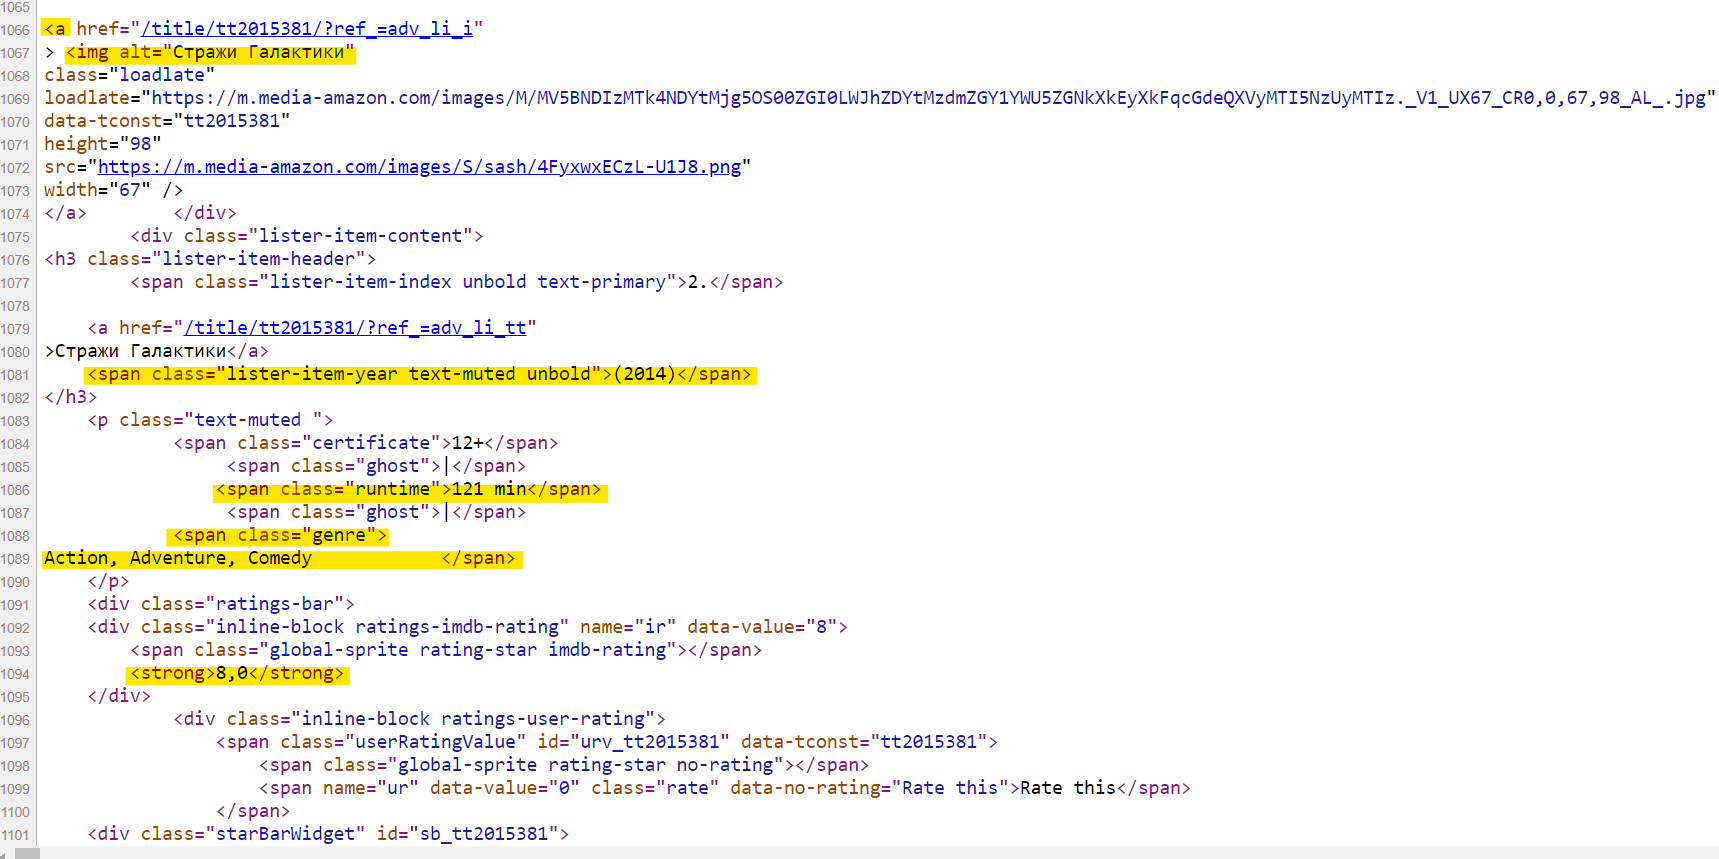

In [6]:
# Вынесем отдельным блоком функцию для забора данных

headers = {"Accept-Language": "en-US,en;q=0.5"}

def get_movie_data(url):
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # находим все элементы div с классом lister-item mode-advanced на странице
    movie_data = soup.find_all('div', class_='lister-item mode-advanced')

    movie_list = []
    for data in movie_data:
        
       
        # создаем пустой словарь movie_dict и добавляем данные по переменным, которые ищем по тегам
        movie_dict = {}
        movie_dict['Movie Name'] = data.h3.a.text
        movie_dict['Year of Release'] = data.h3.find('span', class_='lister-item-year').text.strip('()').strip('II) (')
        movie_dict['Runtime'] = data.find('span', class_='runtime').text.strip('min')
        movie_dict['Genre'] = data.find('span', class_="genre").text.strip()
        movie_dict['Movie Rating'] = data.strong.text
        
        #добавляем в словарь metascore фильма, который находится внутри тега span с классом metascore, если такой тег существует
        movie_dict['Metascore of Movie'] = data.find('span', class_='metascore').text.strip() if data.find('span', class_='metascore') else '0'
        
        
        value = data.find_all('span', attrs = {'name': 'nv'})
        
        # добавляем в словарь количество голосов за фильм и заменяет запятые на пустые строки, чтобы далее анализировать данные 
        vote = value[0]
        movie_dict['Votes'] = vote.text.replace(',', '')
        #сохраняем в переменную grosses значение второго элемента из value, если такой элемент существует, иначе оставляем пустую строку
        grosses = value[1].text if len(value) >1 else ''
        movie_dict['Gross'] = grosses if grosses else ''
        
        
        #добавляем в словарь описание к фильму
        description = data.find_all('p', class_='text-muted')
        movie_dict['Description'] = description[-1].text.strip() if description else ''
        
        #добавляем словарь  в список movie_list
        movie_list.append(movie_dict)

    return movie_list

In [7]:
# Применяем функцию для каждой страницы с данными и сохрняем результаты сначала в лист, потом преобразуем в датафрейм

urls = ['https://www.imdb.com/search/title/?groups=top_1000&start={}&ref_=adv_nxt'.format(start) for start in range(1, 1001, 50)]
movie_list = []
for url in urls:
    movie_list += get_movie_data(url)

df = pd.DataFrame(movie_list)

In [8]:
df.head()

,Movie Name,Year of Release,Runtime,Genre,Movie Rating,Metascore of Movie,Votes,Gross,Description
0,Guardians of the Galaxy Vol. 3,2023,150,"Action, Adventure, Comedy",8.3,64,102470,#138,"Still reeling from the loss of Gamora, Peter Q..."
1,Guardians of the Galaxy,2014,121,"Action, Adventure, Comedy",8.0,76,1209976,$333.18M,A group of intergalactic criminals must pull t...
2,John Wick: Chapter 4,2023,169,"Action, Crime, Thriller",8.2,78,146661,#199,John Wick uncovers a path to defeating The Hig...
3,Guardians of the Galaxy Vol. 2,2017,136,"Action, Adventure, Comedy",7.6,67,707790,$389.81M,The Guardians struggle to keep together as a t...
4,Dune,2021,155,"Action, Adventure, Drama",8.0,74,672338,$108.33M,A noble family becomes embroiled in a war for ...


## Шаг 3: Предварительныя обработка

In [9]:
# преобразуем переменный в числовой формат
df['Year of Release'] = df['Year of Release'].apply(int)
df['Runtime'] = df['Runtime'].apply(int)
df['Movie Rating'] = df['Movie Rating'].apply(float)
df['Metascore of Movie'] = df['Metascore of Movie'].apply(int)
df['Votes'] = df['Votes'].apply(int)

In [10]:
# преобразуем переменную Gross в числовой формат, предварительно убрав лишние данные, которые начинаются с "#"
df['Gross'] = df['Gross'].apply(lambda x: float(x.replace('$', '').replace('M', '').replace('#', '')) if isinstance(x, str) and x != '' else x)
df['Gross'] = df['Gross'].replace('', pd.NA)
df['Gross'] = pd.to_numeric(df['Gross'], errors='coerce')

In [11]:
df.head()

,Movie Name,Year of Release,Runtime,Genre,Movie Rating,Metascore of Movie,Votes,Gross,Description
0,Guardians of the Galaxy Vol. 3,2023,150,"Action, Adventure, Comedy",8.3,64,102470,138.00,"Still reeling from the loss of Gamora, Peter Q..."
1,Guardians of the Galaxy,2014,121,"Action, Adventure, Comedy",8.0,76,1209976,333.18,A group of intergalactic criminals must pull t...
2,John Wick: Chapter 4,2023,169,"Action, Crime, Thriller",8.2,78,146661,199.00,John Wick uncovers a path to defeating The Hig...
3,Guardians of the Galaxy Vol. 2,2017,136,"Action, Adventure, Comedy",7.6,67,707790,389.81,The Guardians struggle to keep together as a t...
4,Dune,2021,155,"Action, Adventure, Drama",8.0,74,672338,108.33,A noble family becomes embroiled in a war for ...


In [13]:
# проверяем типы объектов в датафрейме
df.dtypes

Movie Name             object
Year of Release         int64
Runtime                 int64
Genre                  object
Movie Rating          float64
Metascore of Movie      int64
Votes                   int64
Gross                 float64
Description            object
dtype: object

In [14]:
# Теперь можем составлять корреляционные матрицы для количественных переменных
df.corr()

,Year of Release,Runtime,Movie Rating,Metascore of Movie,Votes,Gross
Year of Release,1.000000,0.215447,-0.080536,-0.080582,0.239925,0.228502
Runtime,0.215447,1.000000,0.273517,-0.076473,0.158865,0.136380
Movie Rating,-0.080536,0.273517,1.000000,-0.049007,0.482860,0.127401
Metascore of Movie,-0.080582,-0.076473,-0.049007,1.000000,0.240788,0.112308
Votes,0.239925,0.158865,0.482860,0.240788,1.000000,0.543428
Gross,0.228502,0.136380,0.127401,0.112308,0.543428,1.000000


In [15]:
#Обработаем категориальную переменную жанр: преобразуем столбец в 3 столбца, по количеству жанров, описанных на сайте
df[['Genre 1', 'Genre 2']] = df['Genre']. str.split(',', 1 , expand= True )
df[['Genre 2', 'Genre 3']] = df['Genre 2']. str.split(',', 1 , expand= True )
df.head()

,Movie Name,Year of Release,Runtime,Genre,Movie Rating,Metascore of Movie,Votes,Gross,Description,Genre 1,Genre 2,Genre 3
0,Guardians of the Galaxy Vol. 3,2023,150,"Action, Adventure, Comedy",8.3,64,102470,138.00,"Still reeling from the loss of Gamora, Peter Q...",Action,Adventure,Comedy
1,Guardians of the Galaxy,2014,121,"Action, Adventure, Comedy",8.0,76,1209976,333.18,A group of intergalactic criminals must pull t...,Action,Adventure,Comedy
2,John Wick: Chapter 4,2023,169,"Action, Crime, Thriller",8.2,78,146661,199.00,John Wick uncovers a path to defeating The Hig...,Action,Crime,Thriller
3,Guardians of the Galaxy Vol. 2,2017,136,"Action, Adventure, Comedy",7.6,67,707790,389.81,The Guardians struggle to keep together as a t...,Action,Adventure,Comedy
4,Dune,2021,155,"Action, Adventure, Drama",8.0,74,672338,108.33,A noble family becomes embroiled in a war for ...,Action,Adventure,Drama


In [16]:
df = df.drop('Genre', axis=1)

In [17]:
df.head()

,Movie Name,Year of Release,Runtime,Movie Rating,Metascore of Movie,Votes,Gross,Description,Genre 1,Genre 2,Genre 3
0,Guardians of the Galaxy Vol. 3,2023,150,8.3,64,102470,138.00,"Still reeling from the loss of Gamora, Peter Q...",Action,Adventure,Comedy
1,Guardians of the Galaxy,2014,121,8.0,76,1209976,333.18,A group of intergalactic criminals must pull t...,Action,Adventure,Comedy
2,John Wick: Chapter 4,2023,169,8.2,78,146661,199.00,John Wick uncovers a path to defeating The Hig...,Action,Crime,Thriller
3,Guardians of the Galaxy Vol. 2,2017,136,7.6,67,707790,389.81,The Guardians struggle to keep together as a t...,Action,Adventure,Comedy
4,Dune,2021,155,8.0,74,672338,108.33,A noble family becomes embroiled in a war for ...,Action,Adventure,Drama


In [18]:
#сохраним файл в табличку Excel
df.to_excel("Top_100_1_IMDB_Movies.xlsx")

 #### Продолжаем Exploratory Data Analysis

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Movie Name          1000 non-null   object 
 1   Year of Release     1000 non-null   int64  
 2   Runtime             1000 non-null   int64  
 3   Movie Rating        1000 non-null   float64
 4   Metascore of Movie  1000 non-null   int64  
 5   Votes               1000 non-null   int64  
 6   Gross               843 non-null    float64
 7   Description         1000 non-null   object 
 8   Genre 1             1000 non-null   object 
 9   Genre 2             890 non-null    object 
 10  Genre 3             637 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 86.1+ KB


__Переменные:__

- `Movie Name` - название фильма
- `Year of Release` - год выпуска
- `Runtime` - продолжительность, в минутах
- `Genre 1, Genre 2, Genre 3` - жанры
- `Movie Rating` - рейтинг фильма
- `Metascore of Movie` - "considered the rating of a film", фильмы получат Metascore только в том случае, если будут собраны по крайней мере четыре рецензии критиков
- `Votes` - количество голосов
- `Gross` - "кассовость", сумма денег с проката
- `Description` - описание фильма

In [20]:
df.describe()

,Year of Release,Runtime,Movie Rating,Metascore of Movie,Votes,Gross
count,1000.000000,1000.000000,1000.000000,1000.0000,1.000000e+03,843.000000
mean,1991.637000,124.103000,7.968400,66.5800,3.158291e+05,74.073938
std,24.104445,28.712067,0.274512,30.7134,3.816183e+05,116.726314
min,1920.000000,45.000000,7.600000,0.0000,2.551500e+04,0.000000
25%,1975.000000,103.000000,7.800000,64.0000,6.188400e+04,3.485000
50%,1999.000000,120.000000,7.900000,77.0000,1.563575e+05,25.540000
75%,2011.000000,138.000000,8.100000,86.0000,4.362525e+05,99.240000
max,2023.000000,321.000000,9.300000,100.0000,2.738964e+06,936.660000


In [21]:
df.isna().sum()

Movie Name              0
Year of Release         0
Runtime                 0
Movie Rating            0
Metascore of Movie      0
Votes                   0
Gross                 157
Description             0
Genre 1                 0
Genre 2               110
Genre 3               363
dtype: int64

У количественных переменных, кроме Gross пропусков нет. По 157 фильмам нет данных по сумме денег с проката. В таком случае, мы думаем чем заполнить пустые значения. Средним по жанру? Медианой по страрне? и тд. Посоветуйте, пожалуйста, как в таком случае корректнее работать с пропущенными значеними?

У каждого фильма указан как минимум один жанр (Столбец Genre 1 заполнен полностью). Два жанра или три - опционально, но у большинства фильмов указано 3 жанра.

## Шаг 4: Визуализация

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
plt.style.use('ggplot')  # стиль для графиков
%matplotlib inline

Гистограмма распределения длительности фильмов. Большинство фильмов имеют длительность от 90 до 120 минут

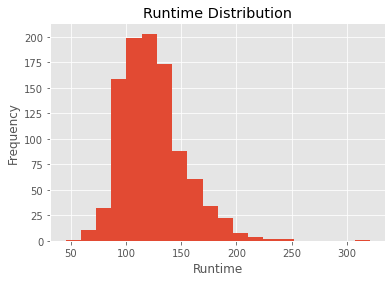

In [23]:
plt.hist(df['Runtime'], bins=20)
plt.xlabel('Runtime')
plt.ylabel('Frequency')
plt.title('Runtime Distribution')
plt.show()

Гистограмма распределения года выпуска фильмов в датафрейме. Можно увидеть периоды, когда количество выпущенных фильмов было особенно высоким или низким

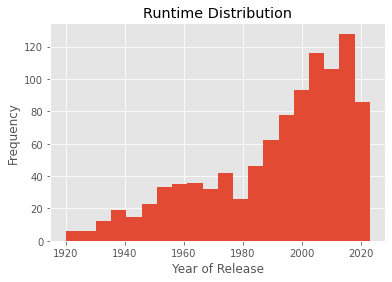

In [24]:
plt.hist(df['Year of Release'], bins=20)
plt.xlabel('Year of Release')
plt.ylabel('Frequency')
plt.title('Runtime Distribution')
plt.show()

Ящик с усами (boxplot) для распределения рейтинга фильмов. Медианное значение примерно 7.85. Есть выбросы верхней границы

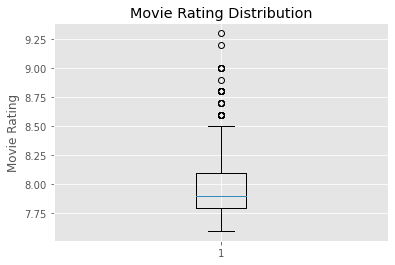

In [25]:
plt.boxplot(df['Movie Rating'])
plt.ylabel('Movie Rating')
plt.title('Movie Rating Distribution')
plt.show()

График, показывающий суммарную выручку фильмов  по годам. В 1994-96 годах выручка была минимальной, как и в 2020 году

<AxesSubplot:xlabel='Year of Release'>

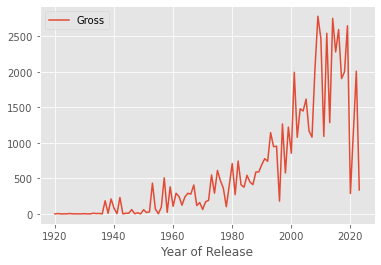

In [26]:
revenue_df = df[['Gross'] + ['Year of Release']]
revenue_df.groupby('Year of Release').sum().plot()

График распределения metascore фильмов. Есть отрицательные значения, возможно, в датасете есть неисправленные значения

<AxesSubplot:xlabel='Metascore of Movie', ylabel='Density'>

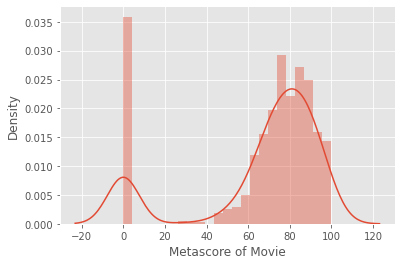

In [29]:
sns.distplot(df['Metascore of Movie'])

## Шаг 5. Создание новых признаков

1) Можно создать новый признак, который будет отображать соотношение сборов фильма к его продолжительности

Таким образом, мы создаем новый признак, который показывает количество денег, которое фильм зарабатывает за одну минуту показа.  Этот признак может быть полезен для анализа эффективности фильма в финансовом плане.

In [35]:
df['Gross_per_Minute'] = df['Gross'] / df['Runtime']
df

,Movie Name,Year of Release,Runtime,Movie Rating,Metascore of Movie,Votes,Gross,Description,Genre 1,Genre 2,Genre 3,Description length,Gross_per_Minute
0,Guardians of the Galaxy Vol. 3,2023,150,8.3,64,102470,138.00,"Still reeling from the loss of Gamora, Peter Q...",Action,Adventure,Comedy,183,0.920000
1,Guardians of the Galaxy,2014,121,8.0,76,1209976,333.18,A group of intergalactic criminals must pull t...,Action,Adventure,Comedy,115,2.753554
2,John Wick: Chapter 4,2023,169,8.2,78,146661,199.00,John Wick uncovers a path to defeating The Hig...,Action,Crime,Thriller,214,1.177515
3,Guardians of the Galaxy Vol. 2,2017,136,7.6,67,707790,389.81,The Guardians struggle to keep together as a t...,Action,Adventure,Comedy,180,2.866250
4,Dune,2021,155,8.0,74,672338,108.33,A noble family becomes embroiled in a war for ...,Action,Adventure,Drama,152,0.698903
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Airlift,2016,130,7.9,0,57803,NaN,"When Iraq invades Kuwait in August 1990, a cal...",Action,Drama,History,137,NaN
996,Bизoнтеле,2001,110,8.0,0,37622,NaN,"Lives of residents in a small, Anatolian villa...",Comedy,Drama,None,94,NaN
997,Все будет очень хорошо,1998,107,8.1,0,26239,NaN,When Altan swipes prescription drugs from his ...,Comedy,Drama,Thriller,222,NaN
998,"Carry On, Munna Bhai",2006,144,8.0,0,48119,2.22,Munna Bhai embarks on a journey with Mahatma G...,Comedy,Drama,Romance,104,0.015417


2) Также можно создать признак: количество символов в описании. Эту переменную мы планируем сравнить и выявить и выявить зависимости с рейтингами фильмов или Gross. Оценить влияет ли длина описания фильма, на его рейтинг


In [37]:
df['Description length'] = df['Description'].apply(lambda x: len(str(x)))
df

,Movie Name,Year of Release,Runtime,Movie Rating,Metascore of Movie,Votes,Gross,Description,Genre 1,Genre 2,Genre 3,Description length,Gross_per_Minute
0,Guardians of the Galaxy Vol. 3,2023,150,8.3,64,102470,138.00,"Still reeling from the loss of Gamora, Peter Q...",Action,Adventure,Comedy,183,0.920000
1,Guardians of the Galaxy,2014,121,8.0,76,1209976,333.18,A group of intergalactic criminals must pull t...,Action,Adventure,Comedy,115,2.753554
2,John Wick: Chapter 4,2023,169,8.2,78,146661,199.00,John Wick uncovers a path to defeating The Hig...,Action,Crime,Thriller,214,1.177515
3,Guardians of the Galaxy Vol. 2,2017,136,7.6,67,707790,389.81,The Guardians struggle to keep together as a t...,Action,Adventure,Comedy,180,2.866250
4,Dune,2021,155,8.0,74,672338,108.33,A noble family becomes embroiled in a war for ...,Action,Adventure,Drama,152,0.698903
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Airlift,2016,130,7.9,0,57803,NaN,"When Iraq invades Kuwait in August 1990, a cal...",Action,Drama,History,137,NaN
996,Bизoнтеле,2001,110,8.0,0,37622,NaN,"Lives of residents in a small, Anatolian villa...",Comedy,Drama,None,94,NaN
997,Все будет очень хорошо,1998,107,8.1,0,26239,NaN,When Altan swipes prescription drugs from his ...,Comedy,Drama,Thriller,222,NaN
998,"Carry On, Munna Bhai",2006,144,8.0,0,48119,2.22,Munna Bhai embarks on a journey with Mahatma G...,Comedy,Drama,Romance,104,0.015417


## Шаг 6. Гипотезы (максимум 20 баллов)

На данном этапе мы планируем сделать визуализацию для новых признаков и посмотреть взаимосвязи. На основе этого мы выдвенем гипотезы. Планируем проверить их с помощью z-статистики

Например, проверим гипотезу: "количество денег, которое фильм зарабатывает за одну минуту показа  имеет прямую линейную зависимость с количество голосов"

Также хотим категориальную переменную Genre преобразовать в числовой формат и пронаблюдать зависимости с другими переменными. Возможно, таким боразом получится найти интересные взаимосвязи, попытаться предсказать gross per minute в зависимости от комбинации жанров

## Шаг 7. Машинное обучение

Считаем, что в нашем датасете можно предсказать переменную Movie Rating